Advantages;<br>
SVM Classifiers offer good accuracy and perform faster prediction compared to Naïve Bayes algorithm.<br>
They also use less memory because they use a subset of training points in the decision phase.<br>
SVM works well with a clear margin of separation and with high dimensional space.<br>

Disadvantages;<br>
SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes.<br>
It works poorly with overlapping classes and is also sensitive to the type of kernel used.

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
#Loading the Dataframe from Feature_Extraction.ipynb
Dataset = pd.read_pickle("Data_te_std.pkl")
Attack_label = pd.read_pickle("Attack_label.pkl")

### Reducing the Dataset

In [3]:
# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset.shape[0],Dataset.shape[0]/8 , random_state=22)
Dataset_short = pd.DataFrame(Dataset.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])

In [4]:
# Checking distribution before and after sampling
print("Original Dataset proportion: ", Attack_label.value_counts(normalize=True))
print("Reduced Dataset: proportion", Attack_label_short.value_counts(normalize=True))

Original Dataset proportion:  Attack_label
1    0.846001
0    0.153999
Name: proportion, dtype: float64
Reduced Dataset: proportion Attack_label
1               0.847909
0               0.152091
Name: proportion, dtype: float64


### SMOTEENN Oversampling

In [5]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_short, Attack_label_short)
print("Target Shape: ", Attack_label_short.shape)
print("Resampled Target Shape: ", Target_res.shape)

print("Before Oversampling: ", Attack_label_short.value_counts(normalize = True))
print("After Oversampling: ", Target_res.value_counts(normalize = True))

Target Shape:  (19725, 1)
Resampled Target Shape:  (25801, 1)
Before Oversampling:  Attack_label
1               0.847909
0               0.152091
Name: proportion, dtype: float64
After Oversampling:  Attack_label
0               0.50688
1               0.49312
Name: proportion, dtype: float64


In [6]:
X = Dataset_res.to_numpy()
Yl = Target_res.to_numpy(dtype='int')

### Train Test split

In [12]:
# Splitting for calculating Hyperparameter
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.8, random_state=22)
print("X_train Shape: ", X_train.shape)

X_train Shape:  (5160, 36)


In [13]:
# split for validation
X_temp , X_val, Y_temp, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=22)
X_val.shape

(1032, 36)

## Hyperparameter

Deciding Parameters are Kernel and C. (if 'poly' kernel also d = degree)

Random Search

In [10]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
svc = svm.SVC()
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[100, 500]} # parameter grid
rand_eval = RandomizedSearchCV(svc, parameters, cv=3)
search = rand_eval.fit(X_val, Y_val)

print("Hyperparameters: ", search.best_params_)
print("Best score: ", search.best_score_)

Hyperparameters:  {'kernel': 'rbf', 'C': 500}
Best score:  0.8875968992248063


Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[150, 200, 500],}
svc = svm.SVC()
grid_eval = GridSearchCV(svc, parameters, cv=3)
search_grid = grid_eval.fit(X_val,Y_val)

print("Hyperparameters: ", search_grid.best_params_)
print("Best score: ", search_grid.best_score_) 

Hyperparameters:  {'C': 200, 'kernel': 'rbf'}
Best score:  0.8875968992248063


* From Randomsearch and Gridsearch it is evident that,<br>
For **Normalised Dataset** kernel as **poly with a degree of 3 (default) and C of higher value is optimal**.<br>
For **Standardised Dataset** Kernel as **rbf and C of higher value is optimal**.<br>

Higher Value of C means low regularisation, smaller margin, strict classification.
Lower is opposite ofc.

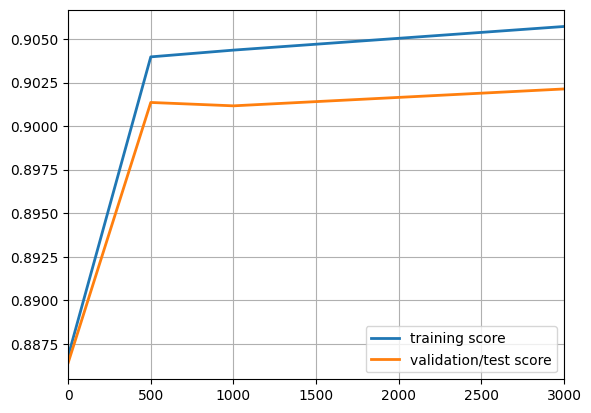

In [14]:
from sklearn.model_selection import validation_curve
C_param = [1, 500, 1000, 3000]
svc = svm.SVC(kernel='rbf')
train_score, test_score = validation_curve(svc, X_train, Y_train, param_name= 'C', param_range= C_param, cv=3)

fig, ax = plt.subplots()
ax.grid()
ax.plot(C_param, train_score.mean(axis=1), linewidth=2.0, label = 'training score')
ax.plot(C_param, test_score.mean(axis=1), linewidth=2.0, label = 'validation/test score')
ax.set(xlim=(0, 3000))
plt.legend()
plt.show()

* Through Validation_curve 
For **normalised Dataset the maximum value of C is found to be 500** after which the test score precedes training score. So C=400 is concluded as Hyperparameter. <br>
For **standardised Dataset the maximum value of C could be 1000** after which Overfitting might occur.


Number of Samples Evaluation

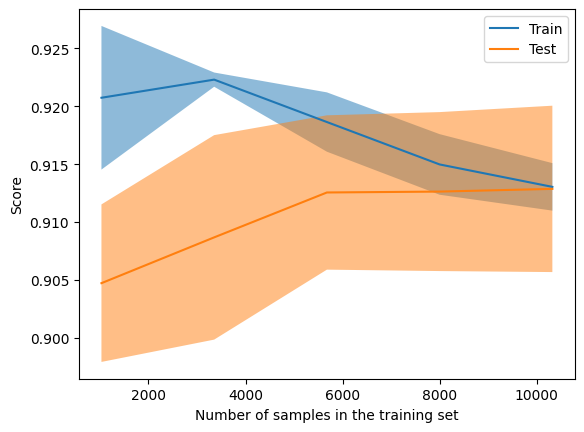

In [15]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.5, random_state=22)
svc = svm.SVC(kernel='rbf', C=1000)
train_sizes, train_scores, test_scores = learning_curve(svc, X_train, Y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()

* For the **Normalised Dataset with Hyperparameter (kernel = poly, degree = 3, C = 400)** the model could be trained well enough from just around **3000 samples**. <br>
For the **Standardised Dataset with Hyperparameter (kernel = rbf, C=500)** the model could be trained only with **4000 samples**.

## SVC with Standardised Dataset

In [9]:
from sklearn import svm
X = Dataset_res.to_numpy() # 19725 sample
Yl = Target_res.to_numpy(dtype='int')
# we need only around 4000 samples so test and training ratio can be only 0.15 and yet we get good result
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, train_size=0.15, random_state=22) 
svc = 
clf = svc.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)svm.SVC(kernel='rbf', C=500)

### Evaluation Metrics

Accuracy: 0.9109023756326661
Precision: 0.9719816062453214
Recall: 0.843057230312587
F1 Score: 0.9029405920921916


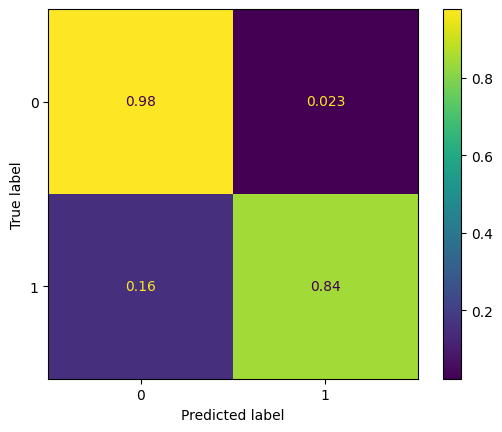

In [10]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Model Precision
print("Precision:",metrics.precision_score(Y_test, Y_pred))
# Model Recall
print("Recall:",metrics.recall_score(Y_test, Y_pred))
# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="binary"))

cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

* Modal have a good F1 Rate, which means good trade off between bias and variance. 

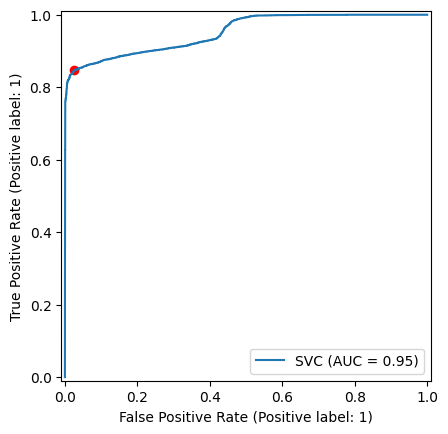

In [42]:
from sklearn.metrics import roc_curve, RocCurveDisplay

Y_score = clf.decision_function(X_test)
fpr, tpr, threshhold = roc_curve(Y_test, Y_score)
RocCurveDisplay.from_estimator(clf, X_test, Y_test)

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
plt.scatter(best_fpr, best_tpr, c = 'red')

* AUROC shows a good value of 0.95, which means that the modal is good at predicting both positive and negative labels.
Low Threshhold value (Red dot) says that the modal will classify more instances as positive (hence more TPR) otherswise called high sensitivity. Moving Threshold right increase Specificity increases and decreases Sensitivity.

## PCA Evaluation

In [11]:
from sklearn.decomposition import PCA
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.5, random_state=22) 
pca = PCA(n_components=30)
pca.fit_transform(X_train)

array([[ 2.19734500e+01, -1.47172555e+00, -8.28561678e-01, ...,
         5.22058732e-02,  1.94315753e-05, -5.79646790e-15],
       [-8.52520020e-01, -7.34430394e-01,  3.08352862e-02, ...,
        -1.29006619e-01, -1.95423640e-05,  3.54443726e-15],
       [-8.32724633e-01, -7.04577149e-01,  2.84668680e-02, ...,
        -1.11748583e-01,  3.21034787e-05,  6.28133789e-16],
       ...,
       [-1.08179482e+00, -1.22644071e+00,  7.12745153e-02, ...,
        -1.22571305e-03, -1.56330234e-05,  3.07365434e-17],
       [-1.13690012e+00, -1.28934972e+00,  7.96511641e-02, ...,
         5.04807600e-02, -7.67533660e-05, -1.35841533e-15],
       [ 1.66238993e+00,  9.95862884e+00,  1.15979242e+01, ...,
         2.91303820e-02, -1.56484953e-05, -7.29178138e-15]])

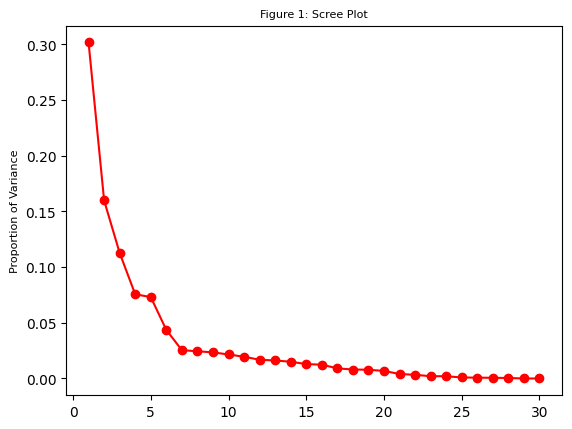

In [27]:
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
PC_numbers = np.arange(pca.n_components_) + 1
 
plt.plot(PC_numbers, prop_var, 'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

Kaiser's rule is based on keeping the components with eigenvalues greater than 1.

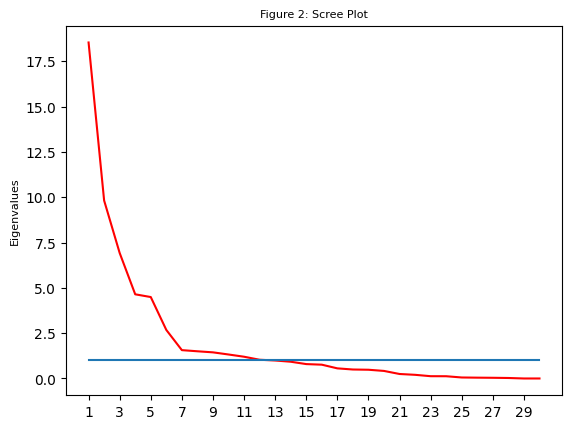

In [29]:
plt.plot(PC_numbers, eigenvalues, 'r')
plt.plot(PC_numbers, np.ones(30))
plt.title('Figure 2: Scree Plot', fontsize=8)
plt.ylabel('Eigenvalues', fontsize=8)
plt.xticks(np.arange(1, 31, 2))
plt.show()

* So the optimal number of Features which could produce the same result as without PCA is just under 15.

## SVC after PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)

X = Dataset_res.to_numpy() # 19725 sample
Yl = Target_res.to_numpy(dtype='int')

X_PCA = pca.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_PCA, Yl, train_size=0.15, random_state=22) 

In [15]:
clf = svc.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

Accuracy: 0.9076193516027541
Precision: 0.9611292531338881
Recall: 0.8463036824042297
F1 Score: 0.9000690539607379


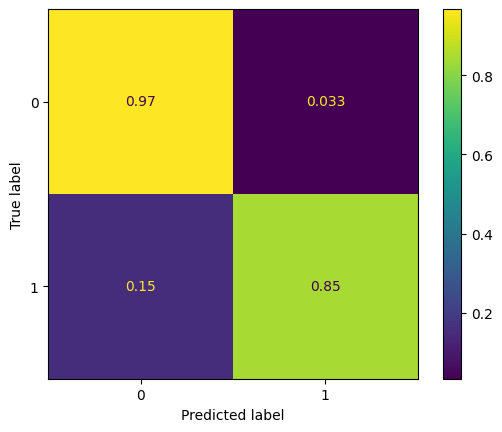

In [16]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Model Precision
print("Precision:",metrics.precision_score(Y_test, Y_pred))
# Model Recall
print("Recall:",metrics.recall_score(Y_test, Y_pred))
# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="binary"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=clf.classes_, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

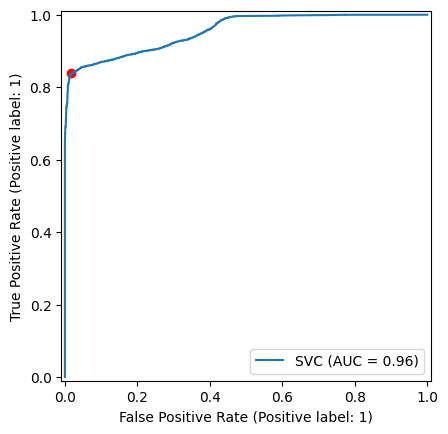

In [48]:
from sklearn.metrics import roc_curve, RocCurveDisplay

Y_score = clf.decision_function(X_test)
fpr, tpr, threshhold = roc_curve(Y_test, Y_score)
RocCurveDisplay.from_estimator(clf, X_test, Y_test)

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
plt.scatter(best_fpr, best_tpr, c = 'red')

## SVC after RF Feature Selection

In [17]:
import pickle as pkl
Features = pkl.load(open("Features_RFFS.pkl", "rb"))

X_rffs = Dataset_res[Features].to_numpy()
Yl = Target_res.to_numpy(dtype='int')

X_train, X_test, Y_train, Y_test = train_test_split(X_rffs, Yl, train_size=0.15, random_state=22) 
print("Train set: ", X_train.shape) 
print("Test set: ", X_test.shape) 

Train set:  (3870, 11)
Test set:  (21931, 11)


In [18]:
clf = svc.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

Accuracy: 0.9089416807259131
Precision: 0.9803149606299213
Recall: 0.8314627585567201
F1 Score: 0.8997741530740276


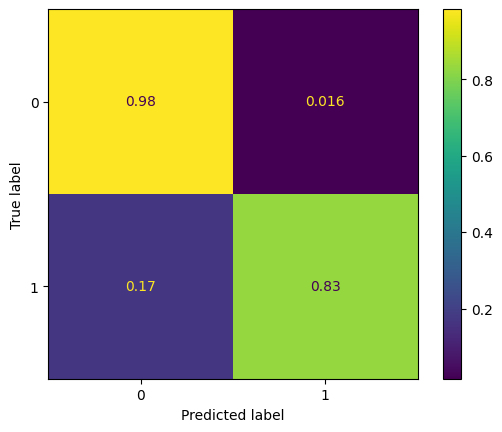

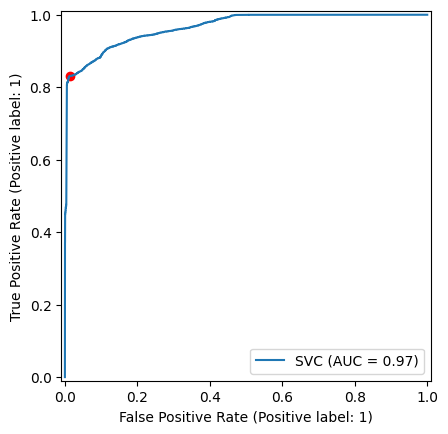

In [19]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Model Precision
print("Precision:",metrics.precision_score(Y_test, Y_pred))
# Model Recall
print("Recall:",metrics.recall_score(Y_test, Y_pred))
# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="binary"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=clf.classes_, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

from sklearn.metrics import roc_curve, RocCurveDisplay

Y_score = clf.decision_function(X_test)
fpr, tpr, threshhold = roc_curve(Y_test, Y_score)
RocCurveDisplay.from_estimator(clf, X_test, Y_test)

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
plt.scatter(best_fpr, best_tpr, c = 'red')

##  Modal SVC with Normalised Dataset

In [52]:
# loading the normalized dataset
Dataset_norm = pd.read_pickle("Data_te_norm.pkl")
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])

# oversampling the dataset
Dataset_res, Target_res = sm.fit_resample(Dataset_norm_short, Attack_label_short)

X = Dataset_res.to_numpy() # 19725 sample
Yl = Target_res.to_numpy(dtype='int')

# we need only around 3000 samples so test and training ratio can be only 0.15 and yet we get good result
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, train_size=0.15, random_state=22) 

svc = svm.SVC(kernel='poly', C=400)
clf = svc.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

Evaluation

Accuracy: 0.7254735525375268
Precision: 0.9974478945129732
Recall: 0.43333641319412364
F1 Score: 0.6041867954911433


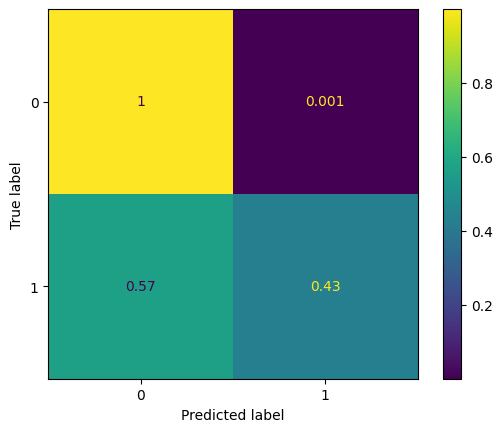

In [54]:
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Model Precision
print("Precision:",metrics.precision_score(Y_test, Y_pred))
# Model Recall
print("Recall:",metrics.recall_score(Y_test, Y_pred))
# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="binary"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=clf.classes_, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

* The modal is very good at predicting abnormal Datasample. (Precision = 1)

Best Threshhold:  (0.0013839633249718881, 0.43851057932181464)


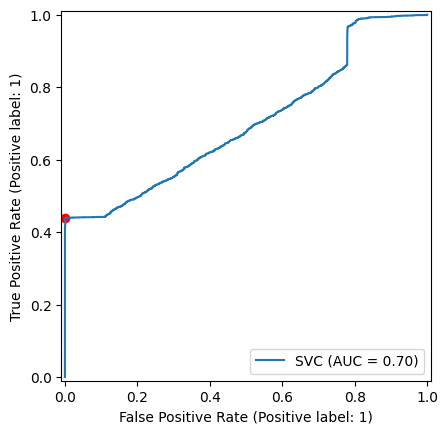

In [55]:
from sklearn.metrics import roc_curve, RocCurveDisplay

Y_score = clf.decision_function(X_test)
fpr, tpr, threshhold = roc_curve(Y_test, Y_score)
RocCurveDisplay.from_estimator(clf, X_test, Y_test)

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
plt.scatter(best_fpr, best_tpr, c = 'red')
print("Best Threshhold: ", (best_fpr, best_tpr))

* Area under ROC is equal to 0.74.<br> 
which means that the model is not good at predicting both positives and negatives.

***

## Conclusion

The Dataset is Loaded and sampled 1/8 of the original dataset with almost same distribution of labels, because for the
SVM algorithm not too many samples are needed. Then with the help of these sampled dataset the modal is validated for Hyperparamters. With Random-Search and Grid-Search the Kernel for the modal is determined. Then with the help of validation-curve optimal value for the C parameter is determined. Finally with Learning Curve minimum number of samples to train a optimum modal is calculated.<br>

**The Result shows that SVC Model of Hyperparameter, C=500, Kernel=rbf, Samples=4000 produce good accuracy, F1 Score, AUROC, for a standardised Dataset. Through PCA the dimensionality can be reduced to less than half as well as the training time.** <br>

**The result doesnt match the Paper from Edge IIoTset!!**<br>

By Normalised Dataset the SVC gives an undesirable results. (low AUROC)
